In [1]:
from IPython.display import Image
Image(url="image/plasmonic_structure.png", width=200, height=300)

In [2]:
import time
import numpy as np;
import os
import matplotlib.pyplot as plt

from src1.Outils import read_data_nk,Interpolate_Optical_Index
from src1.Outils import Polarization_vector,Diag2Matrix
from src1.Geometry import Circle 
from src1.CONV import convmat2D
from src1.Computation import Optical_Response

from src1.Scattering import homogeneous, PQ_matrix,S_matrix_layer,redheffer_global
from src1.Plane import redheffer_global_plane,S_matrix_layer_plane,trn_matrix,ref_matrix

import warnings
warnings.filterwarnings("ignore")

# Parameters

In [3]:
AOI_r=0; Azimuth_r=0 # in radians
wavelength_range=np.linspace(1000,1600,81) 

## Optical index

In [4]:
path_optical_index=os.getcwd()+'/dataNK/'
path_Si=path_optical_index+ 'c-Si_HJY_Modif.txt'
path_SiO2=path_optical_index+ 'SiO2_HJY_Modif.txt'
path_Al=path_optical_index+ 'Al_McPeak.txt'
path_Ge=path_optical_index+ 'Ge_Nunley.txt'

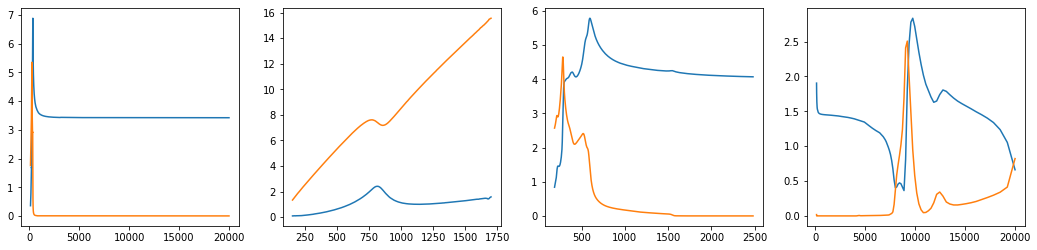

In [5]:
# Source parameters
h=4.135667516*1e-15;#[eV s]      
c=299792458         #[m/s]

Si_wl, Si_n, Si_k=read_data_nk(path_Si)
Si_wl=h*c/Si_wl*10**9      #eV to nm

SiO2_wl, SiO2_n,SiO2_k=read_data_nk(path_SiO2)
SiO2_wl=h*c/SiO2_wl*10**9  #eV to nm

Al_wl, Al_n, Al_k=read_data_nk(path_Al)
Al_wl=Al_wl*1000  # um to nm

Ge_wl, Ge_n, Ge_k=read_data_nk(path_Ge)
Ge_wl=Ge_wl*1000 # um to nm

fig_size=(18,4)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4,figsize=fig_size)

ax1.plot(Si_wl,Si_n)
ax1.plot(Si_wl,Si_k)
 
ax4.plot(SiO2_wl,SiO2_n)
ax4.plot(SiO2_wl,SiO2_k)

ax2.plot(Al_wl,Al_n)
ax2.plot(Al_wl,Al_k)

ax3.plot(Ge_wl,Ge_n)
ax3.plot(Ge_wl,Ge_k)
plt.show()

In [6]:
#Interpolate for optical index
t0=time.time()
#Si
N_Si=Interpolate_Optical_Index(wavelength_range,Si_wl, [Si_n,Si_k])
e_Si=np.conj(N_Si**2)

#SiO2
N_SiO2=Interpolate_Optical_Index(wavelength_range,SiO2_wl, [SiO2_n,SiO2_k])
e_SiO2=np.conj(N_SiO2**2)

#Al
N_Al=Interpolate_Optical_Index(wavelength_range,Al_wl, [Al_n,Al_k])
e_Al=np.conj(N_Al**2)

#Ge
N_Ge=Interpolate_Optical_Index(wavelength_range,Ge_wl, [Ge_n,Ge_k])
e_Ge=np.conj(N_Ge**2)

#reflection and transmission medium
u_ref=1;     e_ref=1.321**2;        #water:  n_water=1.321  
u_trn=1;     e_trn=np.copy(e_Si);   e_air=1  

t1=time.time()
print(t1-t0)

0.016956090927124023


## Diffraction order

In [7]:
Lx = 950           ;Ly = 950  # pitch
mx=10; my=10                  # diffraction order in x and y directions, mx=my=10 for accurate simulation 
Nharm=(2*mx+1)*(2*my+1)       # harmonic number

## Geometry

In [8]:
parameters=[100,50,50,1000,500/2]  

h0=parameters[0];    h1=parameters[1];    h2=parameters[2];    h3=parameters[3];  
CD=parameters[-1];   #radius

In [9]:
# mesh grid
pixel_length=1 # 1 pixel =1nm
 
Nx = int(Lx/pixel_length);
Ny=int(Ly/pixel_length);

x_center=Nx//2; y_center=Ny//2

#Defining layers
layerAl_0=[[x_center,y_center,CD/pixel_length,'Al','circle'],h0]    

layerSiO2_1= [['SiO2'], h1]
layerSi_2= [['Si'],h2]
layerGe_3= [['Ge'], h3]                 

geometry=[  layerAl_0,            
            layerSiO2_1,
            layerSi_2,
            layerGe_3                 
         ] 
NL=len(geometry)# number of layers
thickness_layer=[geo [-1]for geo in geometry]

In [10]:
# permittivity in Fourier space
t0=time.time()
ERC_CONV=[];

mask0=Circle(Nx,Ny, geometry[0])

t0 = time.time()
for wth in range(len(wavelength_range)): 
    er_vec = [None]*NL;  erc_conv = [None]*NL;  
    # patterned layer 
    er_vec[0]=e_Al[wth]*np.ones((Nx,Ny),dtype='complex')                
    er_vec[0][mask0]=e_ref  # water   
    erc_conv[0] = convmat2D(er_vec[0], mx, my)     
    #homogeneous layers
    erc_conv[1]=np.diag(e_SiO2[wth]*np.ones(Nharm))
    erc_conv[2]=np.diag(e_Si[wth]*np.ones(Nharm))
    erc_conv[3]=np.diag(e_Ge[wth]*np.ones(Nharm))      
    
    ERC_CONV.append(erc_conv)  
t_conv=time.time()-t0

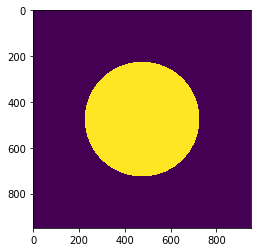

In [11]:
# mesh-grid in x-y plane
plt.imshow(er_vec[0].real)
plt.show()

## RCWA simulation

In [12]:
t0=time.time()       
  
Ref=[]; Trn=[];      
for wth in range(len(wavelength_range)):  
        
    erc_conv = ERC_CONV[wth];  wavelength=wavelength_range[wth];      k0=2*np.pi/wavelength    
    
    # vector component  Kx,Ky          
    n_i =  np.sqrt(e_ref*u_ref)        
    kx_inc = n_i * np.sin(AOI_r) * np.cos(Azimuth_r);
    ky_inc = n_i * np.sin(AOI_r) * np.sin(Azimuth_r);      
    kz_inc = np.sqrt(n_i**2 - kx_inc ** 2 - ky_inc ** 2);
    
    k_x = kx_inc - 2*np.pi*np.arange(-mx, mx+1)/(k0*Lx);
    k_y = ky_inc - 2*np.pi*np.arange(-my, my+1)/(k0*Ly);

    Kx, Ky = np.meshgrid(k_x, k_y);   
            
    Kx= Kx.flatten(order = 'C')
    Ky=Ky.flatten(order = 'C')
        
    # Gap Medium    
    Vg,_ = homogeneous(Kx,Ky, e_air);   
    # reflection medium: superstrate-water    
    Vr,Kzr = homogeneous(Kx,Ky, e_ref);  
    Kzr=-Kzr
    # transmission medium:substrate-Si    
    Vt,Kzt= homogeneous(Kx, Ky, e_trn[wth]) ;         
        
    # Scattering Matrix  of superstrate and substrate medium      
    S_global_11, S_global_21=trn_matrix(Vt,Vg,Nharm, Sim='half') # bottom up: initial global s-matrix = s-matrix of substrate 
    
    S_ref_11,S_ref_12,S_ref_21,S_ref_22=ref_matrix(Vr,Vg,Nharm,Sim='full')  # S_ref is not symmetric matrix  
                                #In case that superstrate is  air, e_air=1. We do not need to do this computation
    
    # Main Loop Iterates Through Layers  
    # Homogeneous layers:using vector-based formation for fast computation related to homogeneous layers            
    for lth in range(NL)[::-1][:3]: # bottom up 
        
        Li = thickness_layer[lth];    e_conv=np.diag(erc_conv[lth])            
        V_i,_=homogeneous(Kx, Ky, e_conv);
        Gamma_squared=Kx*Kx + Ky*Ky -e_conv
        lambda_matrix=np.lib.scimath.sqrt(Gamma_squared.astype('complex'))
        x= np.exp(-lambda_matrix*k0*Li)               
        S11,S12=S_matrix_layer_plane(V_i, Vg,x,Nharm)             
        
        # integrate into global s-matrix
        S_global_11,S_global_21=redheffer_global_plane([S11,S12], [S_global_11,S_global_21],Nharm,Sim='half') 
    
    # The next step is to convert vector to matrix to integrate to grating layer 
    S_global_11=Diag2Matrix(S_global_11)   ;S_global_21=Diag2Matrix(S_global_21)   
    
    S_ref_11=Diag2Matrix(S_ref_11);        S_ref_12=Diag2Matrix(S_ref_12)
    S_ref_21=Diag2Matrix(S_ref_21);        S_ref_22=Diag2Matrix(S_ref_22)       
    S_ref=[S_ref_11,S_ref_12,S_ref_21,S_ref_22]        
        
    Vg=Diag2Matrix(Vg); Vr=Diag2Matrix(Vr)        
    #grating layers
    mu_conv=np.identity(Nharm)
    for lth in range(NL)[::-1][3:]:         
        Li = thickness_layer[lth];    e_conv = erc_conv[lth];       
                
        P, Q = PQ_matrix(np.diag(Kx), np.diag(Ky), e_conv, mu_conv)
        Gamma_squared = P@Q   
                
        Lambda, W_i = np.linalg.eig(Gamma_squared);               
        lambda_matrix = np.lib.scimath.sqrt(Lambda.astype('complex'));   
                
        V_i=Q @ W_i @ np.linalg.inv(np.diag(lambda_matrix))
            
        X = np.diag(np.exp(-lambda_matrix*k0*Li))
            
        S11,S12=S_matrix_layer(V_i, W_i,Vg,X)          
                
        # integrate layer s-matrix into global s-matrix
        S_global_11,S_global_21=redheffer_global([S11,S12,S12,S11], [S_global_11,S_global_21],Nharm,Sim='half')  
    
    # Integrate superstrate s-matrix into global s-matrix
    #In case that superstrate is  air, e_air=1. We do not need to do this computation
    S_global_11,S_global_21=redheffer_global(S_ref, [S_global_11,S_global_21],Nharm,Sim='half')     
    
    # TE: polarization angle=90       
    Polarization_TE=Polarization_vector(AOI_r,Azimuth_r, np.radians(90))              
    rx,ry= Optical_Response(Polarization_TE,S_global_11,Nharm)# reflectance  
    tx,ty= Optical_Response(Polarization_TE,S_global_21,Nharm)# transmittance 
        
    rz=-(Kx*rx[:,0]+Ky*ry[:,0])/Kzr
    r2=np.square(np.abs(rx[:,0])) + np.square(np.abs(rz))+np.square(np.abs(ry[:,0]))
    R=np.real(-Kzr* r2)/np.real(kz_inc)        
    Ref.append(np.sum(R))  
        
    tz=-(Kx*tx[:,0]+Ky*ty[:,0])/Kzt
    t2=np.square(np.abs(tx[:,0])) + np.square(np.abs(ty[:,0]))+ np.square(np.abs(tz))
    T=np.real(Kzt* t2)/np.real(kz_inc)        
    Trn.append(np.sum(T)) 
    
Ref=np.array(Ref)
Trn=np.array(Trn)
t_sim=time.time()-t0

In [ ]:
print(" Total simulation time:{} second".format(t_conv+t_sim))

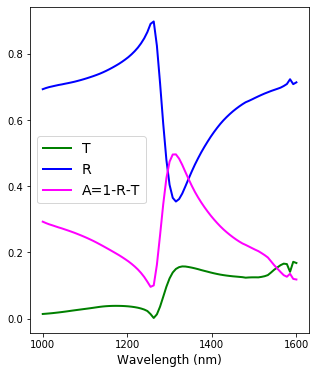

In [13]:
fig_size=(5,6)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=fig_size)
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 

ax.plot(wavelength_range,Trn,c='green',lw=2,label='T')
ax.plot(wavelength_range,Ref,c='blue',lw=2,label='R')
ax.plot(wavelength_range,1-Ref-Trn,c='magenta',lw=2,label='A=1-R-T')
ax.legend(loc="upper right")

ax.legend(prop=dict(size=14))

ax.set_xlabel('Wavelength (nm)',fontsize = 12.0)
plt.show()